### A. Import dữ liệu cần thiết

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import re

In [38]:
trending_videos = pd.read_csv('Data/trending_videos.csv', index_col=False)
trending_videos_unique = pd.read_csv('Data/trending_videos_unique.csv', index_col=False)

In [39]:
# pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None

### B. Trực quan hoá

#### 1. Phân tích tổng quan

##### a. Thời điểm đăng trong ngày của video

In [40]:
upload_time = trending_videos_unique[['published_at']].copy()
upload_time['published_at'] = pd.to_datetime(upload_time['published_at'])
upload_time['hour'] = upload_time['published_at'].dt.hour
time_ranges = [f'{i}h - {i+1}h' for i in range(24)]
video_counts = [upload_time[(upload_time['hour'] >= i) & (upload_time['hour'] < i+1)].shape[0] for i in range(24)]
time_video_df = pd.DataFrame({'Time Range': time_ranges, 'Video Count': video_counts})

In [41]:
time_video_df

,Time Range,Video Count
0,0h - 1h,60
1,1h - 2h,32
2,2h - 3h,18
3,3h - 4h,22
4,4h - 5h,34
5,5h - 6h,25
6,6h - 7h,18
7,7h - 8h,18
8,8h - 9h,34
9,9h - 10h,58


In [42]:
# plt.figure(figsize=(12, 6))
# plt.boxplot(upload_time['hour'], vert=False)
# plt.xlabel('Hour of the Day')
# plt.title('Box Plot of Video Upload Times')
# plt.grid(True)                                                  
# plt.show()
px.box(upload_time, x='hour', title='Box Plot of Video Upload Times')

In [43]:
# time_video_df.plot(x='Time Range', y='Video Count', kind='barh', figsize=(12, 6))
# plt.xlabel('Time Range')
# plt.ylabel('Video Count')
# plt.title('Number of Videos Uploaded in Each Time Range')
# plt.xticks(rotation=0)
# plt.grid(True, axis='x')
# plt.show()
fig = px.bar(time_video_df, x='Time Range', y='Video Count', title='Number of Videos Uploaded in Each Time Range',)
fig.show()

##### b. Thời gian tồn tại trên trending

In [44]:
time_on_trending = trending_videos_unique[['trending_time']].copy()
time_on_trending = time_on_trending.groupby('trending_time').size().reset_index(name='frequency')
time_on_trending['trending_time'] = pd.to_timedelta(time_on_trending['trending_time'])
time_on_trending = time_on_trending.sort_values(by='trending_time')
time_on_trending

,trending_time,frequency
0,1 days,148
11,2 days,133
18,3 days,153
19,4 days,187
20,5 days,190
21,6 days,200
22,7 days,218
23,8 days,191
24,9 days,159
1,10 days,143


In [45]:
time_on_trending['days_on_trending'] = time_on_trending['trending_time'].dt.days
# plt.figure(figsize=(12, 6))
# plt.boxplot(time_on_trending['days_on_trending'], vert=False)
# plt.xlabel('Days on Trending')
# plt.title('Box Plot of Number of Days Videos Stayed on Trending')
# plt.grid(True)
# plt.show()
px.box(time_on_trending, x='days_on_trending')

In [46]:
# time_on_trending.plot(x='days_on_trending', y='frequency', kind='bar', figsize=(12, 6))
# plt.xlabel('Trending Time (Days)')
# plt.ylabel('Frequency')
# plt.title('Frequency of Videos on Trending by Duration')
# plt.xticks(rotation=0)
# plt.grid(True, axis='y')
# plt.show()
px.bar(time_on_trending,x='days_on_trending', y='frequency',labels={'days_on_trending':'Days','frequency':'Videos'})

#### 2. Phân tích theo chủ đề

##### a. Phần trăm của từng chủ đề trên trending

In [47]:
category_counts = trending_videos['category'].copy().value_counts()
category_full = category_counts.reset_index()
category_full

,category,count
0,Entertainment,6551
1,People & Blogs,4992
2,Music,1269
3,Gaming,1207
4,Comedy,770
5,Sports,609
6,Howto & Style,538
7,News & Politics,489
8,Film & Animation,432
9,Pets & Animals,271


In [48]:
threshold = 400
category_pie = category_full.copy()
category_pie['category'] = category_pie['category'].apply(lambda x: x if category_counts[x] >= threshold else 'Others')
category_pie = category_pie.groupby('category').sum()
# category_pie.plot(kind='pie', y='count', autopct='%1.1f%%', figsize=(10, 8))
# plt.title('Tỉ lệ phần trăm của từng chủ đề')
# plt.show()

px.pie(category_pie, values='count', names=category_pie.index, title='Tỉ lệ phần trăm của từng chủ đề')

##### b. Trung bình lượt tương tác theo chủ đề

In [49]:
pd.options.display.float_format = None
general_category = trending_videos[['category', 'view_count', 'like_count', 'comment_count']]

general_category = general_category.groupby('category').mean().reset_index()

general_category['like_to_view'] = (general_category['like_count'] / general_category['view_count']) * 100
general_category['comment_to_view'] = (general_category['comment_count'] / general_category['view_count'])* 100
general_category

,category,view_count,like_count,comment_count,like_to_view,comment_to_view
0,Autos & Vehicles,3.107792e+06,6.514688e+04,373.597222,2.096243,0.012021
1,Comedy,2.000528e+07,3.692852e+05,885.325974,1.845939,0.004425
2,Education,1.414157e+07,1.423025e+05,689.653846,1.006271,0.004877
3,Entertainment,1.565211e+07,4.495979e+05,5875.157075,2.872443,0.037536
4,Film & Animation,2.598126e+07,1.114053e+06,1956.761574,4.287909,0.007531
5,Gaming,1.139973e+07,4.372097e+05,1862.311516,3.835263,0.016336
6,Howto & Style,3.435267e+07,6.074260e+05,834.693309,1.768206,0.002430
7,Music,1.078366e+07,3.371908e+05,27022.155240,3.126868,0.250584
8,News & Politics,2.137084e+06,3.040098e+04,686.476483,1.422545,0.032122
9,People & Blogs,1.713809e+07,3.889904e+05,1859.762220,2.269742,0.010852


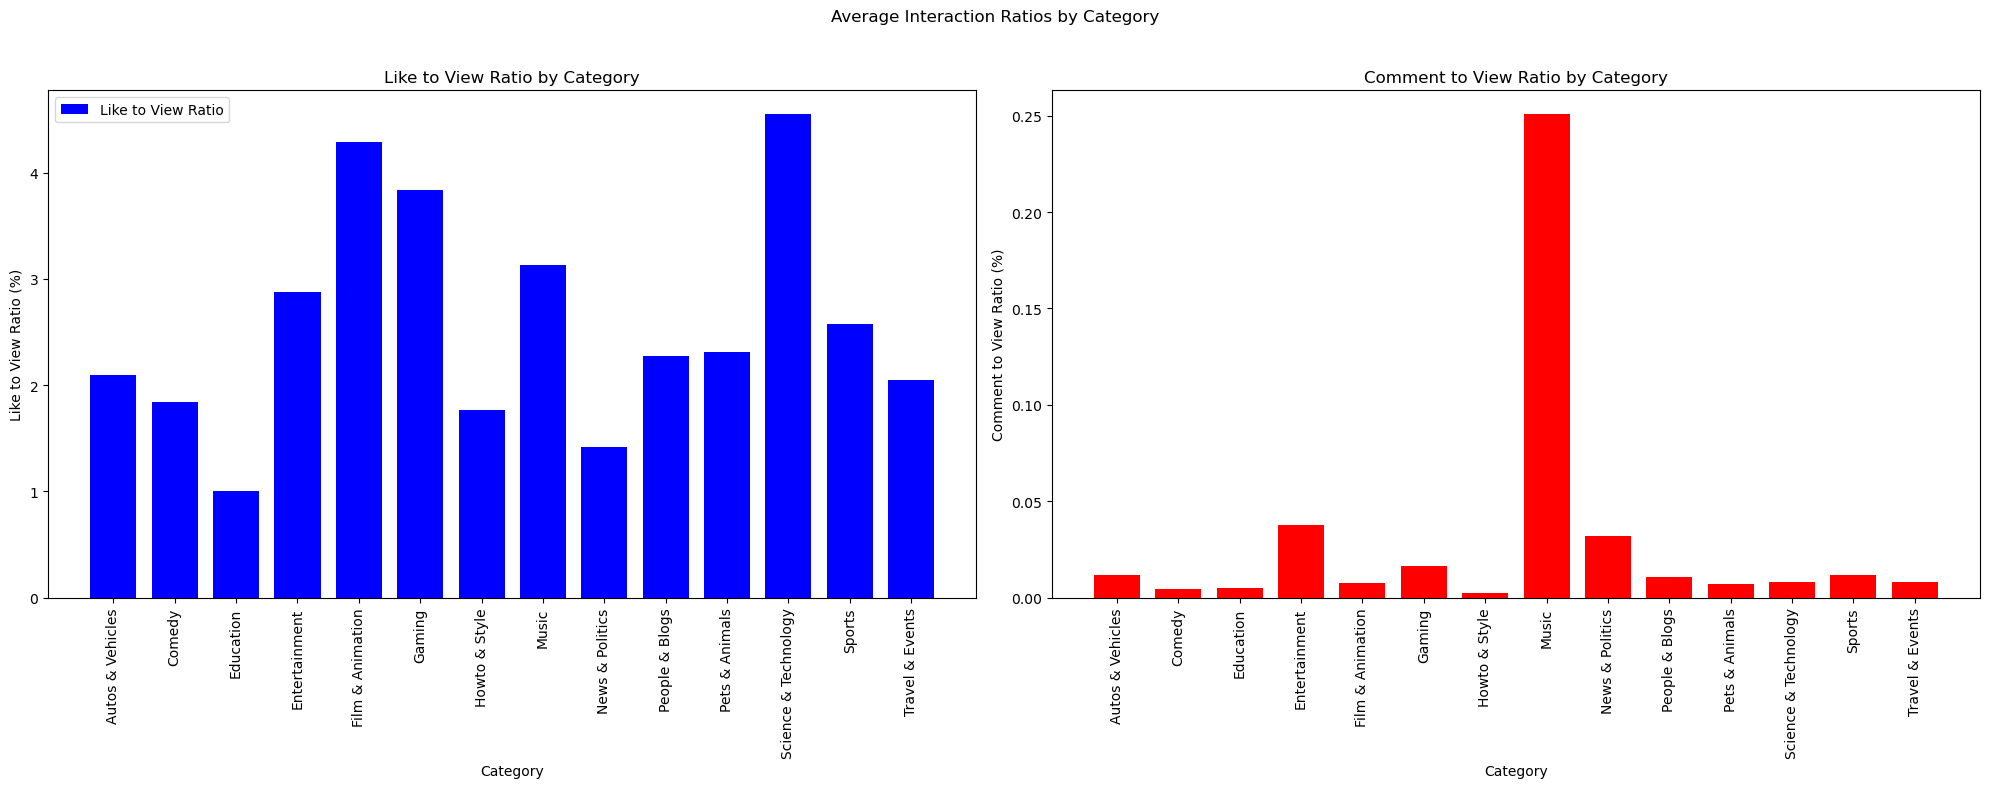

In [50]:
x = range(len(general_category['category']))
width = 0.75
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes[0].bar(x, general_category['like_to_view'], width=width, label='Like to View Ratio', color='b')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Like to View Ratio (%)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(general_category['category'], rotation=90)
axes[0].tick_params(axis='y')
axes[0].set_title('Like to View Ratio by Category')
axes[0].legend()

axes[1].bar(x, general_category['comment_to_view'], width=width, label='Comment to View Ratio', color='r')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Comment to View Ratio (%)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(general_category['category'], rotation=90)
axes[1].tick_params(axis='y')
axes[1].set_title('Comment to View Ratio by Category')

plt.suptitle('Average Interaction Ratios by Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### c. Thời gian trending trung bình của chủ đề

In [51]:
# pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None
trending_category = trending_videos_unique[['category', 'trending_time']].copy()
trending_category['trending_time'] = pd.to_timedelta(trending_category['trending_time'])
trending_category = trending_category.groupby('category').mean()
trending_category = trending_category / np.timedelta64(1, 'h')
trending_category


,trending_time
category,
Autos & Vehicles,219.000000
Comedy,167.357143
Education,212.000000
Entertainment,198.564356
Film & Animation,162.830769
Gaming,150.523077
Howto & Style,170.805195
Music,247.680000
News & Politics,148.148148


In [52]:
# trending_category.plot(kind='barh', color='skyblue', figsize=(10, 6))
# plt.title('Average Trending Time by Category')
# plt.xlabel('Average Trending Time (hours)')
# plt.ylabel('Category')
# plt.grid(True, axis='x')
# plt.xticks(rotation=0)
# plt.show()
trending_category = trending_category.sort_values('trending_time')
px.bar(trending_category, x=trending_category['trending_time'], y=trending_category.index, labels={'x': 'Category', 'y': 'Average Trending Time (hours)'}, title='Average Trending Time by Category')

#### 3. Phân tích theo nội dung chi tiết

##### a. Từ khoá trong tag

In [53]:
video_tags = trending_videos_unique['video_tags'].copy()
video_tags = video_tags.dropna()
tags_list = []
for tagline in video_tags:
    tags_list.extend(tagline.split(','))
count_tags = Counter(tags_list)
tags_df = pd.DataFrame(count_tags.items(),columns=['tag','count'])
tags_df_sort = tags_df.sort_values('count',ascending=True).tail(25)
tags_df_sort

,tag,count
321,trực tiếp giải liên quân,57
314,đấu trường danh vọng,60
311,garena liên quân,61
315,garena liên quân mobile,61
316,aov,61
317,garena,61
312,liên quân mobile,61
313,liên quân,62
746,phim ngắn,65
319,Esports,72


In [54]:
# tags_df_sort.plot(kind='barh', figsize=(9, 6))
# plt.xlabel('Count')
# plt.ylabel('Tag')
# plt.title('Top 25 Tags by Count')
# plt.grid(True, axis='x')
# plt.xticks(rotation=0)
# plt.show()

px.bar(tags_df_sort, x='count', y='tag', title='Top 25 Tags by Count',height=600,width=800)

##### b. Độ dài tiêu đề

In [55]:
titles = trending_videos_unique['title'].copy()

def clean_title(title):
    return re.sub(r'[^\w\s]', '', title, flags=re.UNICODE)

def get_len_title(title):
    title = title.strip()
    return len(title.split(' '))

cleaned_title = titles.apply(clean_title)
len_titles = cleaned_title.apply(get_len_title)
count_len = Counter(len_titles)
len_df = pd.DataFrame(count_len.items(),columns=['len','count'])
len_df_to_plot = len_df.sort_values('len',ascending=True)
len_df_to_plot

,len,count
17,1,50
19,2,52
6,3,75
14,4,95
12,5,102
13,6,111
2,7,109
3,8,110
1,9,144
7,10,157


In [56]:
# plt.figure(figsize=(12, 6))
# plt.boxplot(len_titles, vert=False)
# plt.xlabel('Title Length (words)')
# plt.title('Box Plot of Title Lengths')
# plt.grid(True)
# plt.show()

px.box(len_df_to_plot,x='len')

In [57]:
# len_df_to_plot.plot(kind='bar', figsize=(12, 6))
# plt.title('Distribution of Title Lengths')
# plt.xlabel('Title Length (words)')
# plt.ylabel('Count')
# plt.grid(True, axis='y')
# plt.xticks(rotation=0)
# plt.show()

px.bar(len_df_to_plot,x='len',y='count')

#### 4. Phân tích theo thời gian

##### a. Độ dài video theo thời gian

In [58]:
duration_videos = trending_videos[['snapshot_date', 'duration']].copy()
duration_videos['month'] = pd.to_datetime(duration_videos['snapshot_date']).dt.to_period('W')
bins = [pd.Timedelta(minutes=0), pd.Timedelta(minutes=1), pd.Timedelta(minutes=10), pd.Timedelta(minutes=60), pd.Timedelta(hours=24)]
labels = ['<1p', '1-10p', '10-60p', '>60p']
duration_videos['duration_time'] = pd.cut(duration_videos['duration'], bins=bins, labels=labels, right=False)
duration_videos = duration_videos.groupby(['month', 'duration_time'], observed=False).size().unstack(fill_value=0)
duration_videos = duration_videos.reset_index()

In [59]:
duration_videos

duration_time,month,<1p,1-10p,10-60p,>60p
0,2023-10-30/2023-11-05,84,82,29,45
1,2023-11-06/2023-11-12,88,122,27,97
2,2023-11-13/2023-11-19,89,89,37,114
3,2023-11-20/2023-11-26,115,86,59,79
4,2023-11-27/2023-12-03,134,78,35,90
5,2023-12-04/2023-12-10,201,66,18,54
6,2023-12-11/2023-12-17,221,51,19,42
7,2023-12-18/2023-12-24,152,78,38,54
8,2023-12-25/2023-12-31,146,63,57,56
9,2024-01-01/2024-01-07,170,50,35,49


In [60]:
for col in duration_videos.columns[1:]:
    duration_videos[col] = duration_videos[col].cumsum()


In [61]:
duration_videos['month'] = duration_videos['month'].astype(str)
duration_videos_long = duration_videos.melt(id_vars='month', 
											var_name='time', 
											value_name='count')
fig = px.bar(duration_videos_long, 
             x='count', 
             y='time',
             orientation='h', 
             color='time', 
             animation_frame='month', 
             title='Video Duration Over Time',
             labels={'count': 'Number of Videos', 'time': 'Duration Range', 'month': 'Month'},
             text='count')
fig.update_layout(xaxis_title="Number of Videos", 
                  yaxis_title="Duration Range",
                  showlegend=False)
fig.show()

In [62]:
# # # pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None
# duration_percentage = duration_videos.div(duration_videos.sum(axis=1), axis=0) * 100
# duration_percentage

In [63]:
# duration_percentage.plot(kind='line', figsize=(12, 6))
# plt.title('Phần trăm của từng thời lượng video theo thời gian')
# plt.xlabel('Thời gian')
# plt.ylabel('Phần trăm')
# plt.legend(title='Độ dài')
# plt.show()

##### b. Chủ đề theo thời gian

In [90]:
video_counts = 300
category_area = trending_videos[['snapshot_date', 'category']].copy()
category_area['category'] = category_area['category'].apply(lambda x: x if category_counts[x] >= video_counts else 'Others')
category_area = category_area.groupby(['snapshot_date', 'category']).size().unstack(fill_value=0)
category_area.index = pd.to_datetime(category_area.index)
category_area['month'] = category_area.index.to_period('W')
category_area = category_area.groupby('month').sum()
category_area = category_area.reset_index()

In [91]:
for col in category_area.columns[1:]:
    category_area[col] = category_area[col].cumsum()

In [92]:
category_area['month'] = category_area['month'].astype(str)
category_area_long = category_area.melt(id_vars='month', 
											var_name='categories', 
											value_name='count')
category_area_long = category_area_long.sort_values(by=['month', 'count'], ascending=[True, False])

fig = px.bar(category_area_long, 
             x='count', 
             y='categories',
             orientation='h', 
             color='categories', 
             animation_frame='month', 
             title='Video Duration Over Time',
             labels={'count': 'Number of Videos', 'categories': 'Duration Range', 'month': 'Month'},
             text='count',
             height=600)
# fig.update_layout(xaxis_title="Number of Videos", 
#                   yaxis_title="Duration Range",
#                   showlegend=False)
# fig.show()
category_area_long['categories'] = pd.Categorical(category_area_long['categories'], 
                                                  categories=category_area_long.groupby('categories')['count'].sum().sort_values(ascending=False).index)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()

# Update the animation settings for smoother transitions
# fig.update_layout(
#     updatemenus=[{
#         'buttons': [
#             {
#                 'args': [None, {
#                     'frame': {'duration': 120, 'redraw': True},
#                     'fromcurrent': True,
#                     'transition': {'duration': 120, 'easing': 'linear'}
#                 }],
#                 'label': '&#9654;',
#                 'method': 'animate'
#             },
#             {
#                 'args': [[None], {
#                     'frame': {'duration': 0, 'redraw': True},
#                     'mode': 'immediate',
#                     'transition': {'duration': 0, 'easing': 'linear'}
#                 }],
#                 'label': '&#9724;',
#                 'method': 'animate'
#             }
#         ],
#         'direction': 'left',
#         'pad': {'r': 10, 't': 70},
#         'showactive': False,
#         'type': 'buttons',
#         'x': 0.1,
#         'xanchor': 'right',
#         'y': 0,
#         'yanchor': 'top'
#     }]
# )
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {
                    'frame': {'duration': 40, 'redraw': True},  # Giảm thời gian mỗi khung (50ms)
                    'fromcurrent': True,
                    'transition': {'duration': 40, 'easing': 'cubic-in-out'}  # Sử dụng easing mượt
                }],
                'label': '&#9654;',  # Nút Play
                'method': 'animate'
            },
            {
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }],
                'label': '&#9724;',  # Nút Stop
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 70},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Thêm easing vào trục thời gian
fig.update_traces(marker=dict(line=dict(width=0)), selector=dict(type='bar'))
fig.update_layout(
    transition=dict(duration=300, easing="cubic-in-out")  # Chuyển đổi mượt mà
)






In [67]:
# pd.options.display.float_format = None

# category_area = category_area.div(category_area.sum(axis=1), axis=0) * 100
# category_area.plot(kind='area', figsize=(12, 6))
# plt.title('Percentage of Each Category per Month')
# plt.xlabel('Month')
# plt.ylabel('Percentage')
# plt.legend(title='Category')
# plt.show()

##### c. Trung bình tương tác theo thời gian

In [68]:
pd.options.display.float_format = '{:,.0f}'.format

general_videos = trending_videos[["view_count", "like_count", "comment_count"]].copy()
general_videos.describe()

,view_count,like_count,comment_count
count,"17,512","17,512","17,512"
mean,"16,631,531","440,410","5,097"
std,"29,073,052","1,001,456","22,914"
min,"187,782",0,0
25%,"1,703,761","28,766",135
50%,"3,495,725","63,612",427
75%,"17,990,534","323,578","2,064"
max,"290,801,447","11,040,218","438,822"


In [69]:
general_month = trending_videos[["snapshot_date", "view_count", "like_count", "comment_count"]].copy()

general_month['snapshot_date'] = pd.to_datetime(general_month['snapshot_date'])

general_month['snapshot_date'] = general_month['snapshot_date'].dt.to_period('M')

general_month = general_month.groupby('snapshot_date').mean().reset_index()

general_month

,snapshot_date,view_count,like_count,comment_count
0,2023-11,"7,774,582","209,155","7,430"
1,2023-12,"8,396,831","247,525","3,497"
2,2024-01,"11,770,799","308,438","2,803"
3,2024-02,"16,946,634","421,504","3,429"
4,2024-03,"19,947,261","515,162","6,439"
5,2024-04,"18,610,296","520,917","4,341"
6,2024-05,"22,734,065","600,849","3,302"
7,2024-06,"20,153,998","526,412","6,100"
8,2024-07,"21,877,066","660,230","9,501"
9,2024-08,"16,164,299","434,596","6,374"


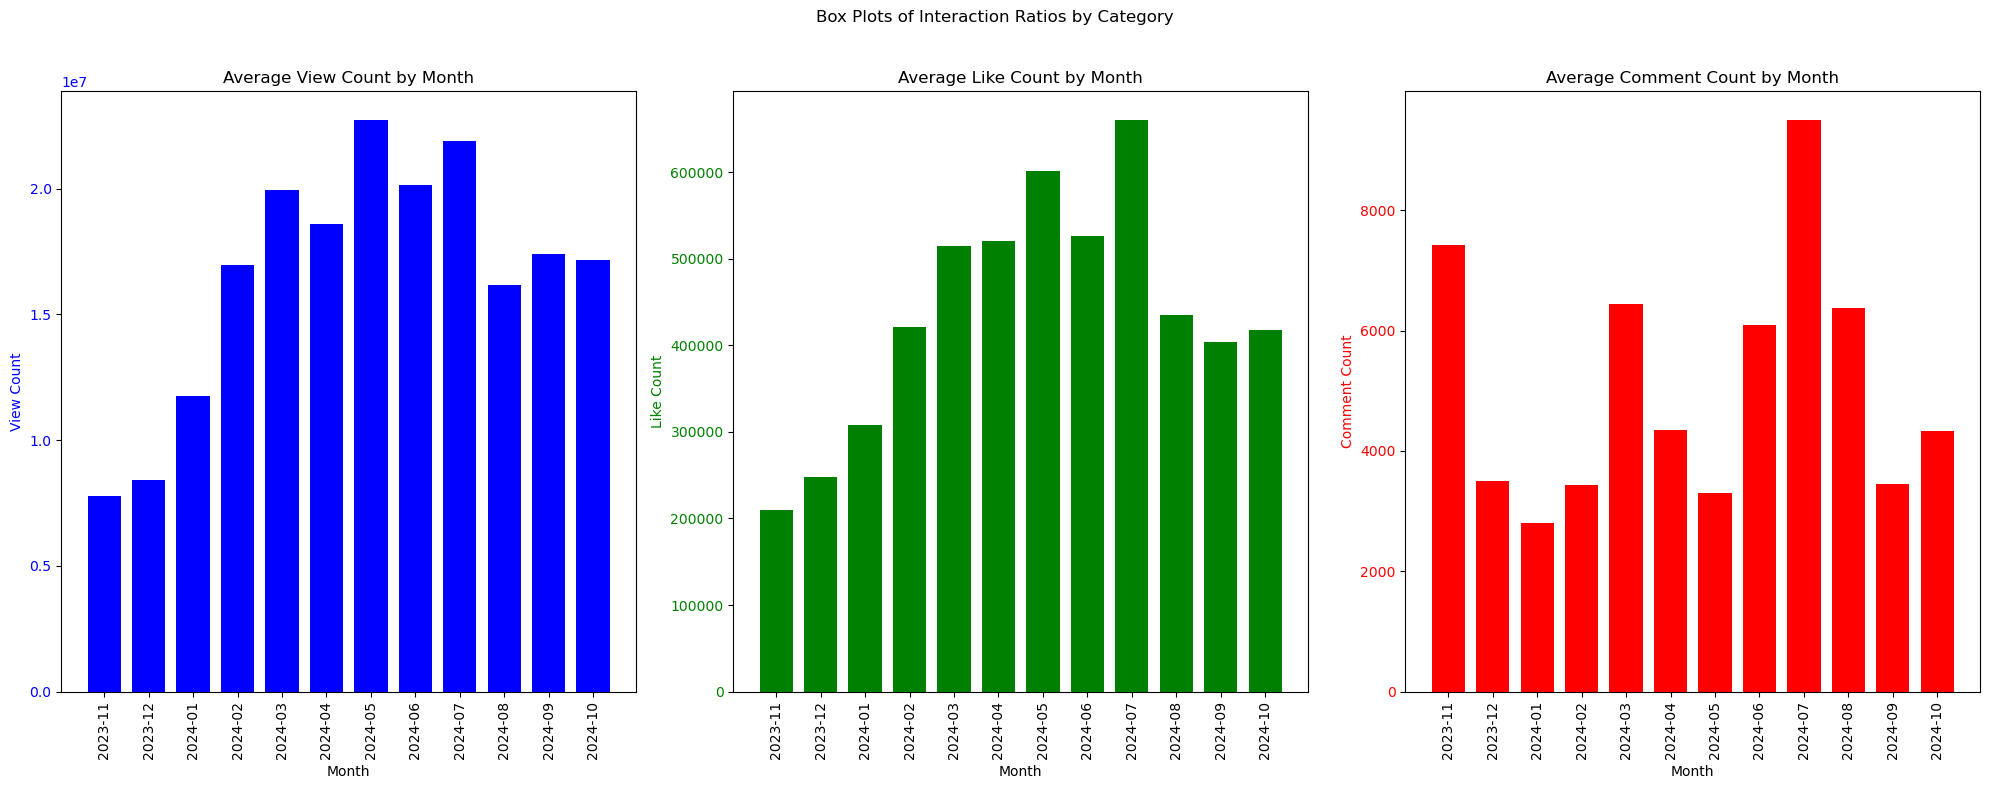

In [70]:
x = range(len(general_month['snapshot_date']))
width = 0.75
ig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

axes[0].bar(x, general_month['view_count'], width=width, label='View Count', color='b')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('View Count', color='b')
axes[0].set_xticks(x)
axes[0].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[0].tick_params(axis='y', labelcolor='b')
axes[0].set_title('Average View Count by Month')

axes[1].bar(x, general_month['like_count'], width=width, label='Like Count', color='g')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Like Count', color='g')
axes[1].set_xticks(x)
axes[1].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[1].tick_params(axis='y', labelcolor='g')
axes[1].set_title('Average Like Count by Month')

axes[2].bar(x, general_month['comment_count'], width=width, label='Comment Count', color='r')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Comment Count', color='r')
axes[2].set_xticks(x)
axes[2].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[2].tick_params(axis='y', labelcolor='r')
axes[2].set_title('Average Comment Count by Month')

plt.suptitle('Box Plots of Interaction Ratios by Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()